In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns

# Set device: use GPU if available, else CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cuda


In [2]:
# Load the dataset
df = pd.read_csv("IL_T500_cleaned.csv")  # Update with your file name/path

# Check for NaNs in each column
print("NaN counts before fixing:\n", df.isnull().sum())

# Fill missing values in 'spectral_contrast' with the column mean
df['spectral_contrast'].fillna(df['spectral_contrast'].mean(), inplace=True)

# Verify that NaNs are resolved
print("\nNaN counts after fixing:\n", df.isnull().sum())


NaN counts before fixing:
 Mean                  0
RMS                   0
Variance              0
Standard Deviation    0
Peak-to-Peak          0
Crest Factor          0
Skewness              0
Kurtosis              0
Energy                0
Entropy               0
Max                   0
Min                   0
peak_magnitude        0
spectral_centroid     0
spectral_bandwidth    0
spectral_flatness     0
spectral_rolloff      0
spectral_entropy      0
spectral_contrast     0
label                 0
dtype: int64

NaN counts after fixing:
 Mean                  0
RMS                   0
Variance              0
Standard Deviation    0
Peak-to-Peak          0
Crest Factor          0
Skewness              0
Kurtosis              0
Energy                0
Entropy               0
Max                   0
Min                   0
peak_magnitude        0
spectral_centroid     0
spectral_bandwidth    0
spectral_flatness     0
spectral_rolloff      0
spectral_entropy      0
spectral_contrast    

In [3]:
# Separate the data into normal and anomaly subsets based on the 'label'
df_normal = df[df['label'] == 0].copy()
df_anomaly = df[df['label'] == 1].copy()
print("Normal data shape:", df_normal.shape)
print("Anomaly data shape:", df_anomaly.shape)

# For training, we use only normal data.
X_normal = df_normal.drop(columns=['label']).values  # shape: (num_normal_samples, num_features)
y_normal = df_normal['label'].values  # will be all zeros

# For testing, use the entire dataset.
X_all = df.drop(columns=['label']).values
y_all = df['label'].values

print("X_normal shape:", X_normal.shape)
print("X_all shape:", X_all.shape)

# Scale features: fit the scaler on normal training data and transform both sets
scaler = MinMaxScaler()
X_normal_scaled = scaler.fit_transform(X_normal)
X_all_scaled = scaler.transform(X_all)

# Set sequence (window) length; here we use 20 timesteps.
timesteps = 20

def create_sequences(data, seq_len):
    sequences = []
    for i in range(len(data) - seq_len + 1):
        sequences.append(data[i : i + seq_len])
    return np.array(sequences)

# Create sequences for training from normal data
X_normal_seq = create_sequences(X_normal_scaled, seq_len=timesteps)
# (For unsupervised training, labels are not used; we can set them to zeros.)
y_normal_seq = np.zeros(len(X_normal_seq), dtype=int)

# Create sequences for testing from the entire dataset.
X_all_seq = create_sequences(X_all_scaled, seq_len=timesteps)
# For test labels, assign the label of the last element in each sequence.
def create_test_labels(labels, seq_len):
    test_labels = []
    for i in range(len(labels) - seq_len + 1):
        test_labels.append(labels[i + seq_len - 1])
    return np.array(test_labels)

y_all_seq = create_test_labels(y_all, seq_len=timesteps)

print("Training sequences shape (normal only):", X_normal_seq.shape)
print("Test sequences shape (all data):", X_all_seq.shape)


Normal data shape: (10000, 20)
Anomaly data shape: (9999, 20)
X_normal shape: (10000, 19)
X_all shape: (19999, 19)
Training sequences shape (normal only): (9981, 20, 19)
Test sequences shape (all data): (19980, 20, 19)


In [4]:
# Convert training sequences (normal data) to PyTorch tensors
X_train_tensor = torch.tensor(X_normal_seq, dtype=torch.float32).to(device)
# We don't need labels for unsupervised training; we wrap only X_train_tensor.
train_dataset = TensorDataset(X_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

# Convert test sequences and their true labels to tensors
X_test_tensor = torch.tensor(X_all_seq, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_all_seq, dtype=torch.long).to(device)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


In [5]:
class LSTMAutoencoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers=2, dropout=0.3):
        super(LSTMAutoencoder, self).__init__()
        # Encoder: compress input sequence into a hidden representation.
        # Note: dropout is applied only if num_layers > 1.
        self.encoder = nn.LSTM(input_dim, hidden_dim, num_layers=num_layers, 
                               dropout=dropout, batch_first=True)
        # Decoder: reconstruct the original sequence from the hidden representation.
        self.decoder = nn.LSTM(hidden_dim, input_dim, num_layers=num_layers, 
                               dropout=dropout, batch_first=True)
        
    def forward(self, x):
        # x shape: (batch, seq_len, input_dim)
        encoded, _ = self.encoder(x)    # encoded: (batch, seq_len, hidden_dim)
        decoded, _ = self.decoder(encoded)  # decoded: (batch, seq_len, input_dim)
        return decoded

# Example instantiation:
input_dim = X_normal_seq.shape[2]  # should be 19 (number of features)
hidden_dim = 64  # experiment with this value if needed
num_layers = 2   # increased from 1 to 2
dropout = 0.3    # 30% dropout between layers

autoencoder = LSTMAutoencoder(input_dim, hidden_dim, num_layers=num_layers, dropout=dropout).to(device)
print(autoencoder)


LSTMAutoencoder(
  (encoder): LSTM(19, 64, num_layers=2, batch_first=True, dropout=0.3)
  (decoder): LSTM(64, 19, num_layers=2, batch_first=True, dropout=0.3)
)


In [6]:
criterion = nn.MSELoss()  # Reconstruction loss (Mean Squared Error)
optimizer = optim.Adam(autoencoder.parameters(), lr=1e-5)

epochs = 30
print("\nTraining LSTM Autoencoder...")
for epoch in range(1, epochs + 1):
    autoencoder.train()
    running_loss = 0.0
    for batch in train_loader:
        X_batch = batch[0]  # each batch is a tensor of shape (batch_size, seq_len, input_dim)
        optimizer.zero_grad()
        X_reconstructed = autoencoder(X_batch)
        loss = criterion(X_reconstructed, X_batch)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    avg_loss = running_loss / len(train_loader)
    print(f"Epoch {epoch}/{epochs} | Loss: {avg_loss:.6f}")



Training LSTM Autoencoder...
Epoch 1/30 | Loss: 0.447366
Epoch 2/30 | Loss: 0.437258
Epoch 3/30 | Loss: 0.423610
Epoch 4/30 | Loss: 0.399396
Epoch 5/30 | Loss: 0.359068
Epoch 6/30 | Loss: 0.312974
Epoch 7/30 | Loss: 0.274537
Epoch 8/30 | Loss: 0.242965
Epoch 9/30 | Loss: 0.214755
Epoch 10/30 | Loss: 0.189750
Epoch 11/30 | Loss: 0.168249
Epoch 12/30 | Loss: 0.150596
Epoch 13/30 | Loss: 0.135583
Epoch 14/30 | Loss: 0.123305
Epoch 15/30 | Loss: 0.113114
Epoch 16/30 | Loss: 0.104561
Epoch 17/30 | Loss: 0.097533
Epoch 18/30 | Loss: 0.091395
Epoch 19/30 | Loss: 0.086071
Epoch 20/30 | Loss: 0.081278
Epoch 21/30 | Loss: 0.076998
Epoch 22/30 | Loss: 0.073097
Epoch 23/30 | Loss: 0.069311
Epoch 24/30 | Loss: 0.065816
Epoch 25/30 | Loss: 0.062338
Epoch 26/30 | Loss: 0.059124
Epoch 27/30 | Loss: 0.055989
Epoch 28/30 | Loss: 0.053061
Epoch 29/30 | Loss: 0.050356
Epoch 30/30 | Loss: 0.047839


In [7]:
autoencoder.eval()
train_errors = []
with torch.no_grad():
    for batch in train_loader:
        X_batch = batch[0]
        X_reconstructed = autoencoder(X_batch)
        # Compute the MSE per sequence (averaging over sequence length and features)
        loss_batch = torch.mean((X_batch - X_reconstructed) ** 2, dim=(1, 2))
        train_errors.extend(loss_batch.cpu().numpy())

train_errors = np.array(train_errors)
threshold = np.mean(train_errors) + .95 * np.std(train_errors)
print("Reconstruction error threshold:", threshold)


Reconstruction error threshold: 0.04669454169925302



Test Set Evaluation:
Accuracy: 97.19%
Precision: 97.82%
Recall: 96.53%
F1-score: 97.17%

Confusion Matrix:
[[9766  215]
 [ 347 9652]]


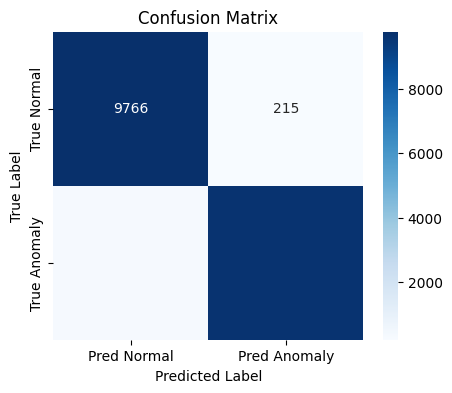

In [8]:
autoencoder.eval()
all_errors = []
all_true = []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_reconstructed = autoencoder(X_batch)
        loss_batch = torch.mean((X_batch - X_reconstructed) ** 2, dim=(1, 2))
        all_errors.extend(loss_batch.cpu().numpy())
        all_true.extend(y_batch.cpu().numpy())

all_errors = np.array(all_errors)
all_true = np.array(all_true)

# Label as anomaly (1) if error > threshold, else normal (0)
y_pred = (all_errors > threshold).astype(int)

print("\nTest Set Evaluation:")
acc  = accuracy_score(all_true, y_pred) * 100
prec = precision_score(all_true, y_pred, zero_division=0) * 100
rec  = recall_score(all_true, y_pred, zero_division=0) * 100
f1   = f1_score(all_true, y_pred, zero_division=0) * 100

print(f"Accuracy: {acc:.2f}%")
print(f"Precision: {prec:.2f}%")
print(f"Recall: {rec:.2f}%")
print(f"F1-score: {f1:.2f}%")

cm = confusion_matrix(all_true, y_pred)
print("\nConfusion Matrix:")
print(cm)

# Optionally, plot the confusion matrix
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Pred Normal", "Pred Anomaly"],
            yticklabels=["True Normal", "True Anomaly"])
plt.title("Confusion Matrix")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.show()
